### Imports

In [178]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize

from sklearn.model_selection import train_test_split
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means


random_seed = 54321
np.random.seed(random_seed)
cwd = os.getcwd()


In [320]:
#for windows
#model_path = cwd + '\\models\\'
#for linux
model_path = cwd + '/models/'

Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [179]:
batch_size=64

In [180]:

tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [181]:
!nvidia-smi

Wed Dec 20 22:32:58 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   53C    P0    40W / 300W |   8780MiB / 16152MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Load Data

In [182]:
data = pd.read_json("Data/train/train.json", orient='records')
data.head()
train_df = data

In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


### Missing values

In [184]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df.tail()

missing values in inc_angle:  133


band_1  \
1599  [-30.999878, -29.976866, -28.233906, -29.50732...   
1600  [-25.31155, -26.511555, -28.694487, -27.180115...   
1601  [-18.141895, -18.141844, -19.01737, -19.701599...   
1602  [-22.455633, -25.794661, -26.954567, -22.83354...   
1603  [-19.909191, -20.678406, -20.208834, -18.42441...   

                                                 band_2        id inc_angle  \
1599  [-27.847719, -28.233864, -24.712077999999998, ...  04e11240        na   
1600  [-29.563713, -28.290375, -26.839405, -28.29046...  c7d6f6f8        na   
1601  [-25.305355, -29.387701, -28.963863, -26.16023...  bba1a0f1        na   
1602  [-26.070356, -22.093737, -21.577662, -24.53376...  7f66bb44        na   
1603  [-24.44487, -24.956001, -27.722103, -26.078417...  9d8f326c        na   

      is_iceberg  inc_angle_f  
1599           0    39.268707  
1600           0    39.268707  
1601           0    39.268707  
1602           0    39.268707  
1603           0    39.268707

### Transform for NN

In [185]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

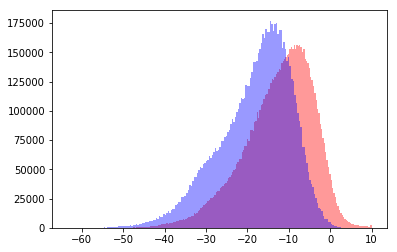

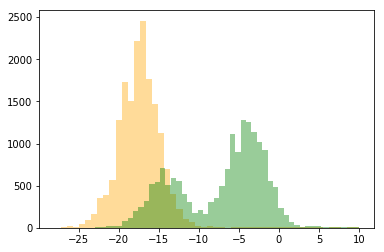

In [186]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

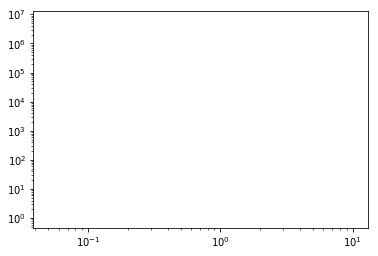

In [187]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

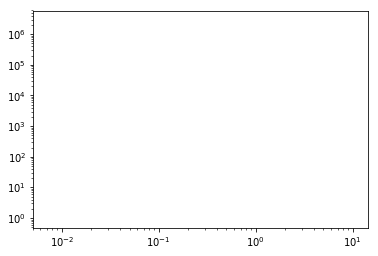

In [188]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [189]:
print(X.max())
print(X.min())
print(X.std())

10.0
-63.464207
9.98626650294


In [190]:
# pre-processing: divide by max and substract mean

#scale = np.max(X_train)
#X_train /= scale

#mean = np.mean(X_train)
#X_train -= mean

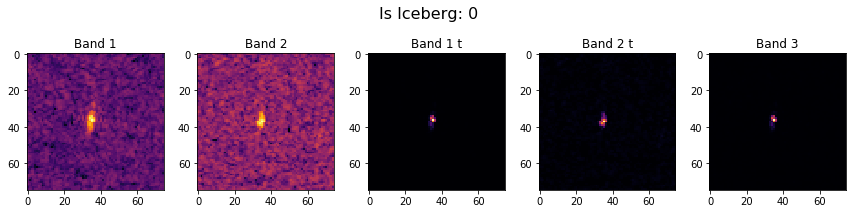

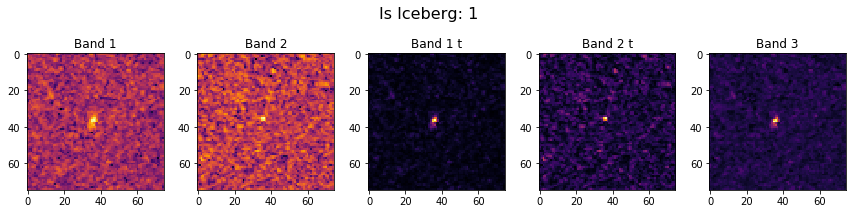

In [191]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


In [192]:
# = to_categorical(train_df.loc[:,'is_iceberg'], num_classes=2)
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index
#y_angle['band_3'] = pd.Series(band_3.tolist()).apply(np.array)

In [193]:
y_angle.head()

is_iceberg  inc_angle_f  index
0           0      43.9239      0
1           0      38.1562      1
2           1      45.2859      2
3           0      43.8306      3
4           0      35.6256      4

### Split into train test and validation sets

In [194]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.3, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1122, 75, 75, 4)
(482, 75, 75, 4)


### Data augmentation

In [288]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3],temp_band_3),axis=3)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        #original_index = temp_data[1][:,2].astype(np.int)
        #denoised_temp = apply_over_axis(denoising, temp_stacked) #denoise all channels
        nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        #filtered_temp = apply_over_axis(img_filtering, temp_data[0], mask=denoised_temp) #filter regional maxima on nn_denoised bands
        #dilated_temp = apply_over_axis(img_dilated, denoised_temp) #use dilated images
        return [temp_stacked1, temp_stacked2, 
                #nn_denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

#flow = datagen.flow(X_train, y_train)
#temp = flow.next()

(1122, 75, 75, 4)


In [289]:
temp = next(datagen_angle.flow(X_train_sample,y_train_sample, batch_size=24).generator)
temp[1][:,1].shape

(24,)

### Denoising

In [198]:
def denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(ndimage.median_filter(image, 3))
    return np.stack(img_list,axis=2)

In [199]:
def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)

In [200]:
X_denoised = apply_over_axis(denoising, X)

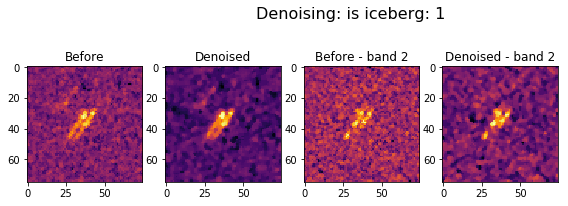

In [201]:
index=8
original_index = y_train_sample.iloc[index].name
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Denoising: is iceberg: %x" % (y_train_sample.iloc[index,0]), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("Denoised")
ax2.imshow(X_denoised[original_index][:,:,0], cmap=cmap)
ax1 = fig.add_subplot(253)
ax1.set_title("Before - band 2")
ax1.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax2 = fig.add_subplot(254)
ax2.set_title("Denoised - band 2")
ax2.imshow(X_denoised[original_index][:,:,1], cmap=cmap)
plt.show()

### Keras model

In [290]:
model_code="CNN_2017_12_19_v15"
model_comment="VOLTA 2 CNN inputs 3,3 conv filters - inception + augmentation angle 20, dropout=0.25"

In [323]:
%%writefile current_model.py

def InceptionBlock(x, n_kernels=64, prefix='', dropout=0.2):
    path1 = Conv2D(n_kernels, (1,1), padding='same', activation='relu', name=prefix + '11_Conv_1_1')(x)
    
    path2 = Conv2D(n_kernels, (1,1), padding='same', activation='relu', name=prefix + '21_Conv_1_1')(x)
    path2 = Conv2D(n_kernels, (3,3), padding='same', activation='relu', name=prefix + '22_Conv_3_3')(path2)
    
    path3 = Conv2D(n_kernels, (1,1), padding='same', activation='relu', name=prefix + '31_Conv_1_1')(x)
    path3 = Conv2D(n_kernels, (5,5), padding='same', activation='relu', name=prefix + '32_Conv_5_5')(path3)
    
    path4 = MaxPooling2D((3,3), strides=(1,1), padding='same', name=prefix + '41_MaxPool_3_3')(x)
    path4 = Conv2D(n_kernels, (1,1), padding='same', activation='relu', name=prefix + '42_Conv_1_1')(path4)
    
    out = Concatenate(axis=3, name=prefix+'_Inception_end')([path1,path2,path3,path4])
    return(out)

def InputBlock(x, dropout=0.2, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    x = InceptionBlock(x,prefix=prefix, dropout=dropout)
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
#aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input', dropout=0.2)
x2 = InputBlock(aux_input, prefix='a_input', dropout=0.2)

x = Concatenate(axis=3)([x1,x2])
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = InceptionBlock(x, prefix='main_path1')
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = InceptionBlock(x, n_kernels=128, prefix='main_path2')
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(1024, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
#flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, x1])

#dense-block
x = Dense(2049, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#dense-block
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                        #aux_input_nn, 
                        angle_input,], 
                        outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

Overwriting current_model.py


In [324]:
%run -i current_model.py

In [325]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

def step_decay2(epoch):
    initial_lrate = 0.000001
    drop = 0.66
    patience = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001):
        self.initial_lrate=initial_lrate

    def step_decay(epoch,logs):
        initial_lrate = self.initial_lrate
        drop = 0.66
        patience = 5.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

def get_callbacks(filepath, patience=10, step_decay=step_decay):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    lrScheduler = LearningRateScheduler(step_decay)
    return [msave, lrScheduler]

In [326]:
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_241 (BatchN (None, 75, 75, 2)    8           main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_243 (BatchN (None, 75, 75, 3)    12          aux_input[0][0]                  
__________________________________________________________________________________________________
conv2d_78 

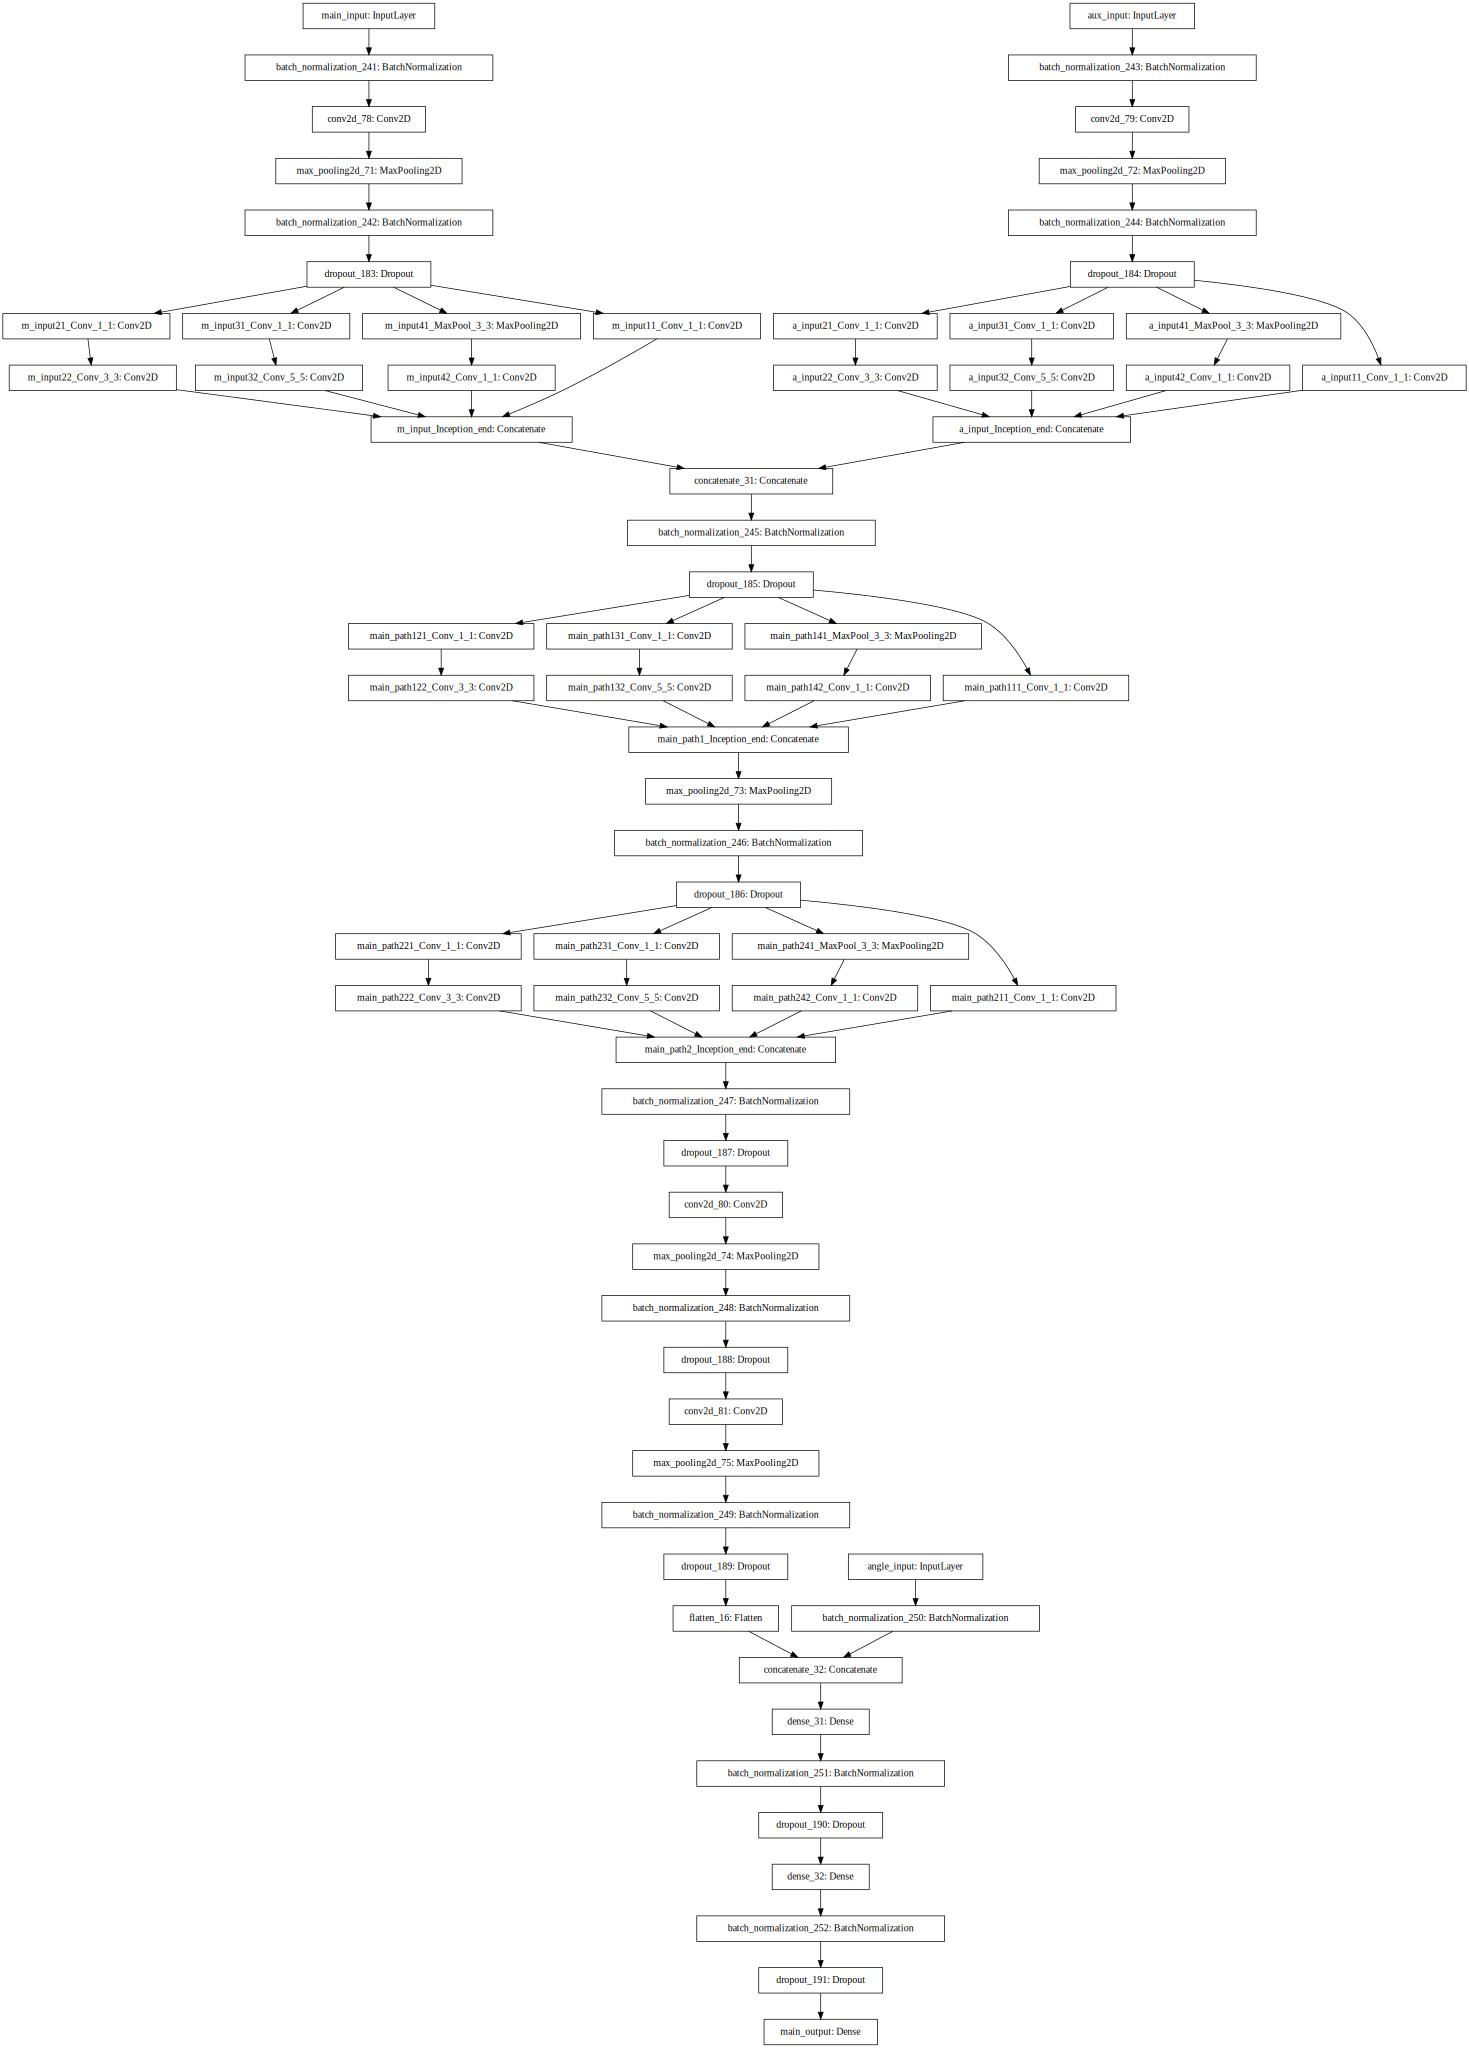

In [327]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

### Model Training

In [328]:
#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay)

In [329]:
#model training
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=batch_size),
                    steps_per_epoch=len(X_train_sample)/batch_size,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=batch_size, shuffle=False), 
                    validation_steps=len(X_val)/(batch_size/2),
                    #validation_data=[X_val,y_val],
                    epochs=56, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  0.001
Epoch 1/56
18/17 [==============================] - 41s 2s/step - loss: 0.9233 - acc: 0.6666 - val_loss: 6.1706 - val_acc: 0.5353
Epoch 2/56
18/17 [==============================] - 5s 258ms/step - loss: 0.5071 - acc: 0.7560 - val_loss: 2.4421 - val_acc: 0.5851
Epoch 3/56
18/17 [==============================] - 3s 148ms/step - loss: 0.4738 - acc: 0.7901 - val_loss: 2.6460 - val_acc: 0.6680
Epoch 4/56
18/17 [==============================] - 3s 149ms/step - loss: 0.4493 - acc: 0.7966 - val_loss: 2.8007 - val_acc: 0.6722
Epoch 5/56
18/17 [==============================] - 3s 148ms/step - loss: 0.4306 - acc: 0.8064 - val_loss: 2.9078 - val_acc: 0.6660
Epoch 6/56
18/17 [==============================] - 3s 148ms/step - loss: 0.3765 - acc: 0.8279 - val_loss: 3.8523 - val_acc: 0.5539
Epoch 7/56
18/17 [==============================] - 3s 149ms/step - loss: 0.3688 - acc: 0.8418 - val_loss: 3.9023 - val_acc: 0.5311
Setting learning rate:  0.00066
Epoch 8/56
18/17

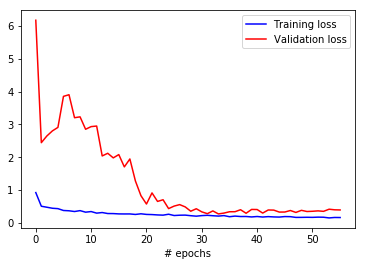

In [330]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [366]:
#addtional training epochs
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay)
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=64),
                    steps_per_epoch=len(X_train_sample)/64,
                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=128, shuffle=False), 
                    validation_steps=len(X_val)/64,
                    #validation_data=[X_val,y_val],
                    epochs=25, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  0.001
Epoch 1/25
18/17 [==============================] - 5s 261ms/step - loss: 0.0861 - acc: 0.9687 - val_loss: 0.7876 - val_acc: 0.8257
Epoch 2/25
18/17 [==============================] - 5s 255ms/step - loss: 0.1320 - acc: 0.9500 - val_loss: 0.3585 - val_acc: 0.8776
Epoch 3/25
18/17 [==============================] - 5s 254ms/step - loss: 0.1129 - acc: 0.9525 - val_loss: 0.3436 - val_acc: 0.8797
Epoch 4/25
18/17 [==============================] - 3s 145ms/step - loss: 0.1123 - acc: 0.9557 - val_loss: 0.4879 - val_acc: 0.8755
Epoch 5/25
18/17 [==============================] - 3s 145ms/step - loss: 0.1112 - acc: 0.9548 - val_loss: 0.5408 - val_acc: 0.8548
Epoch 6/25
18/17 [==============================] - 5s 255ms/step - loss: 0.1222 - acc: 0.9560 - val_loss: 0.3237 - val_acc: 0.9066
Epoch 7/25
18/17 [==============================] - 3s 145ms/step - loss: 0.0950 - acc: 0.9591 - val_loss: 0.3963 - val_acc: 0.8942
Setting learning rate:  0.00066
Epoch 8/25
18/

In [367]:
for key in H.history:
    H.history[key].extend(H2.history[key])

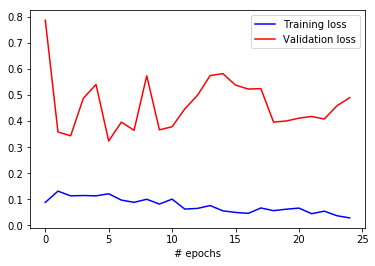

In [368]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

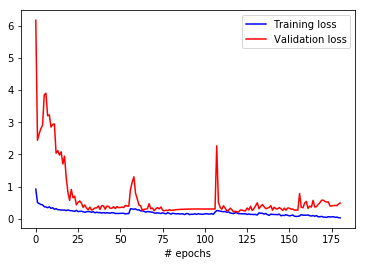

In [369]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [350]:
model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
model_f.save(model_object_path)
#model_f = load_model(model_object_path)

### Saving model history

In [351]:
argmin = np.array(H.history["val_loss"]).argmin()
argmax_acc = np.array(H.history["val_acc"]).argmax()
with open('current_model.py','r') as model_python_code_file:
    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
                                    "val_loss [min]":[H.history['val_loss'][argmin]],
                                    "epoch [val_loss [min]]":argmin,
                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
                                    
                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
                                    "epoch [val_acc [max]]":argmax_acc,
                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
                                    
                                    "model_path":[model_object_path],
                                    "model_weights_path":[model_best_weights_path],
                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
                                    "model_comment":[model_comment]
                                })
                               
models_history = models_history[["timestamp", 
                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
                                 "model_path","model_weights_path","model_python_code","model_comment"]]
models_history.head()

timestamp  epoch [val_loss [min]]  val_loss [min]  \
0  2017_12_20_23_39_40                     120        0.210953   

   training_loss [val_loss [min]]  val_acc [val_loss [min]]  \
0                        0.157278                  0.923237   

   training_acc [val_loss [min]]  epoch [val_acc [max]]  val_acc [max]  \
0                        0.93672                    120       0.923237   

   training_loss [val_acc [max]]  val_loss [val_acc [max]]  \
0                       0.157278                  0.210953   

   training_acc [val_acc [max]]  \
0                       0.93672   

                                          model_path  \
0  /iceberg/models/model.CNN_2017_12_19_v15_2017_...   

                                  model_weights_path  \
0  /iceberg/models/weights.CNN_2017_12_19_v15_201...   

                                   model_python_code  \
0  \ndef InceptionBlock(x, n_kernels=64, prefix='...   

                                       model_comment  
0  VOLTA 2 CNN inputs 3,3 conv filters - inceptio...

In [352]:
print("model comment:", model_comment)
print("Min validation loss epoch:")
print("epoch: %d" %(argmin),
      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
     )
print("Max validation accuracy epoch:")
print("epoch: %d" %(argmax_acc),
      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
     )


model comment: VOLTA 2 CNN inputs 3,3 conv filters - inception + augmentation angle 20, standard dropiout=0.2
Min validation loss epoch:
epoch: 120 ; val loss [min] 0.2110:  ; training loss: 0.1573 ; val acc: 0.9232 ; training acc: 0.9367 
Max validation accuracy epoch:
epoch: 120 ; val loss 0.2110:  ; training loss: 0.1573 ; val acc [max]: 0.9232 ; training acc: 0.9367 


In [353]:
with open('models_history.csv', 'a') as f:
    models_history.to_csv(f, header=False,index=False)
    #models_history.to_csv(f, index=False)

In [354]:
df = pd.read_csv('models_history.csv')
df.tail()

timestamp  epoch [val_loss [min]]  val_loss [min]  \
16  2017_12_20_22_08_54                      45        0.285904   
17  2017_12_20_22_23_00                     104        0.327691   
18  2017_12_20_22_23_00                     104        0.327691   
19  2017_12_20_23_03_06                      52        0.296401   
20  2017_12_20_23_39_40                     120        0.210953   

    training_loss [val_loss [min]]  val_acc [val_loss [min]]  \
16                        0.199626                  0.877593   
17                        0.159640                  0.875519   
18                        0.159640                  0.875519   
19                        0.152571                  0.879668   
20                        0.157278                  0.923237   

    training_acc [val_loss [min]]  epoch [val_acc [max]]  val_acc [max]  \
16                       0.918895                     47       0.881743   
17                       0.931373                     57       0.875519   
18                       0.931373                     57       0.875519   
19                       0.943850                     59       0.887967   
20                       0.936720                    120       0.923237   

    training_loss [val_acc [max]]  val_loss [val_acc [max]]  \
16                       0.188745                  0.310434   
17                       0.157828                  0.352734   
18                       0.157828                  0.352734   
19                       0.162104                  0.300197   
20                       0.157278                  0.210953   

    training_acc [val_acc [max]]  \
16                      0.930481   
17                      0.937611   
18                      0.937611   
19                      0.933155   
20                      0.936720   

                                           model_path  \
16  /iceberg\models\model.CNN_2017_12_19_v15_2017_...   
17  /iceberg\models\model.CNN_2017_12_19_v15_2017_...   
18  /iceberg\models\model.CNN_2017_12_19_v15_2017_...   
19  /iceberg\models\model.CNN_2017_12_19_v15_2017_...   
20  /iceberg/models/model.CNN_2017_12_19_v15_2017_...   

                                   model_weights_path  \
16  /iceberg\models\weights.CNN_2017_12_19_v15_201...   
17  /iceberg\models\weights.CNN_2017_12_19_v15_201...   
18  /iceberg\models\weights.CNN_2017_12_19_v15_201...   
19  /iceberg\models\weights.CNN_2017_12_19_v15_201...   
20  /iceberg/models/weights.CNN_2017_12_19_v15_201...   

                                    model_python_code  \
16  \ndef InceptionBlock(x, n_kernels=32, prefix='...   
17  \ndef InceptionBlock(x, n_kernels=32, prefix='...   
18  \ndef InceptionBlock(x, n_kernels=32, prefix='...   
19  \ndef InceptionBlock(x, n_kernels=32, prefix='...   
20  \ndef InceptionBlock(x, n_kernels=64, prefix='...   

                                        model_comment  
16  VOLTA 2 CNN inputs 3,3 conv filters - inceptio...  
17  VOLTA 2 CNN inputs 3,3 conv filters - inceptio...  
18  VOLTA 2 CNN inputs 3,3 conv filters - inceptio...  
19  VOLTA 2 CNN inputs 3,3 conv filters - inceptio...  
20  VOLTA 2 CNN inputs 3,3 conv filters - inceptio...

In [358]:
model_f = load_model(model_object_path)

In [364]:
model_f.load_weights(model_best_weights_path)

### Predictions

In [355]:
model_best_weights_path

'/iceberg/models/weights.CNN_2017_12_19_v15_2017_12_20_23_39_40.hdf5'

In [ ]:
model_f.load_weights(model_best_weights_path)

In [361]:
model_f.evaluate(X_val,y_val, verbose=1, batch_size=64)

ValueError: The model expects 3 input arrays, but only received one array. Found: array with shape (482, 75, 75, 4)

In [ ]:
test_df = pd.read_json("Data/test/test.json")

In [ ]:
test_df.head()

In [ ]:
t_band_1, t_band_2, t_band_1_t, t_band_2_t, t_band_3, X_test = get_bands(test_df)

In [ ]:
predictions = model.predict(X_test,verbose=1, batch_size=64)

In [ ]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions.reshape(-1)})
submission.head()

In [ ]:
submission.to_csv("submission.v7.csv", index=False)